# 29: Conditional VAE Fisher Overlap Analysis

This notebook trains a conditional VAE where `fc_mean` receives a cluster one-hot
vector concatenated with the final hidden representation, giving the decoder a
routing signal for cluster-specific reconstruction. The Fisher overlap analysis
decomposes the `fc_mean` weights into shared columns (corresponding to hidden
features) and cluster-specific columns (corresponding to the one-hot input),
measuring overlap separately for each block.

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

from vae import vae_loss
from vae_conditional import ConditionalVAE
from fisher_utils import (
    ConditionalAnnDataDataset, compute_conditional_vae_fisher,
    cosine_sim, effective_rank, top_k_overlap,
    vae_layer_category,
)

matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 0.8

OUTPUTS = Path('../outputs')
FIGURES = Path('../figures')
FIGURES.mkdir(exist_ok=True)
(OUTPUTS / 'p6').mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 1. Load data and splits

In [2]:
adata = sc.read_h5ad('../data/adata_processed.h5ad')
print(f'Data: {adata.shape}')

with open(OUTPUTS / 'p1' / 'split_structured.json') as f:
    split = json.load(f)
forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']
all_train_idx = forget_idx + retain_idx
print(f'Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}')

# Cluster distribution
all_labels = adata.obs['leiden'].values[all_train_idx].astype(int)
n_clusters = int(all_labels.max()) + 1
print(f'Clusters: {n_clusters}')
forget_labels = adata.obs['leiden'].values[forget_idx].astype(int)
print(f'Forget cluster(s): {np.unique(forget_labels)}')
for c in range(n_clusters):
    count = (all_labels == c).sum()
    f_count = (forget_labels == c).sum() if c in forget_labels else 0
    if count > 0:
        print(f'  Cluster {c:2d}: {count:5d} train, {f_count:3d} forget')

Data: (33088, 2000)
Forget: 30, Retain: 28094, Unseen: 4964
Clusters: 14
Forget cluster(s): [13]
  Cluster  0:  5795 train,   0 forget
  Cluster  1:  5348 train,   0 forget
  Cluster  2:  4735 train,   0 forget
  Cluster  3:  3845 train,   0 forget
  Cluster  4:  3439 train,   0 forget
  Cluster  5:  1912 train,   0 forget
  Cluster  6:  1843 train,   0 forget
  Cluster  7:   397 train,   0 forget
  Cluster  8:   262 train,   0 forget
  Cluster  9:   204 train,   0 forget
  Cluster 10:   194 train,   0 forget
  Cluster 11:    71 train,   0 forget
  Cluster 12:    49 train,   0 forget
  Cluster 13:    30 train,  30 forget


## 2. Create datasets

In [3]:
train_ds = ConditionalAnnDataDataset(adata, all_train_idx, n_clusters)
val_ds = ConditionalAnnDataDataset(adata, unseen_idx, n_clusters)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')

# Verify dataset output
x_sample, lib_sample, oh_sample = train_ds[0]
print(f'x shape: {x_sample.shape}, lib shape: {lib_sample.shape}, onehot shape: {oh_sample.shape}')

Train: 28124, Val: 4964
x shape: torch.Size([2000]), lib shape: torch.Size([1]), onehot shape: torch.Size([14])


## 3. Initialize conditional VAE

In [4]:
torch.manual_seed(42)
np.random.seed(42)

model = ConditionalVAE(
    n_clusters=n_clusters,
    input_dim=2000,
    hidden_dims=[1024, 512, 128],
    latent_dim=32,
    likelihood='nb',
    dropout=0.1,
    use_layer_norm=True
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f'Conditional VAE: {n_params:,} params')
print()
for name, param in model.named_parameters():
    cat = vae_layer_category(name)
    print(f'  {name:50s} {str(list(param.shape)):20s} {param.numel():>10,d}  [{cat}]')

Conditional VAE: 7,377,984 params

  encoder.network.0.weight                           [1024, 2000]          2,048,000  [Encoder]
  encoder.network.0.bias                             [1024]                    1,024  [Encoder]
  encoder.network.1.weight                           [1024]                    1,024  [Encoder]
  encoder.network.1.bias                             [1024]                    1,024  [Encoder]
  encoder.network.4.weight                           [512, 1024]             524,288  [Encoder]
  encoder.network.4.bias                             [512]                       512  [Encoder]
  encoder.network.5.weight                           [512]                       512  [Encoder]
  encoder.network.5.bias                             [512]                       512  [Encoder]
  encoder.network.8.weight                           [128, 512]               65,536  [Encoder]
  encoder.network.8.bias                             [128]                       128  [Encoder]
  enc

## 4. Train conditional VAE

In [5]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_state = None
best_epoch = 0
start_time = time.time()

for epoch in range(100):
    # Train
    model.train()
    train_loss = 0
    n_train = 0
    for x_batch, lib_batch, cluster_batch in train_loader:
        x_batch = x_batch.to(device)
        lib_batch = lib_batch.to(device)
        cluster_batch = cluster_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch, library_size=lib_batch, cluster_onehot=cluster_batch)
        loss, recon, kl = vae_loss(x_batch, output, likelihood='nb', library_size=lib_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(x_batch)
        n_train += len(x_batch)

    # Validate
    model.train(False)
    val_loss = 0
    n_val = 0
    with torch.no_grad():
        for x_batch, lib_batch, cluster_batch in val_loader:
            x_batch = x_batch.to(device)
            lib_batch = lib_batch.to(device)
            cluster_batch = cluster_batch.to(device)
            output = model(x_batch, library_size=lib_batch, cluster_onehot=cluster_batch)
            loss, _, _ = vae_loss(x_batch, output, likelihood='nb', library_size=lib_batch)
            val_loss += loss.item() * len(x_batch)
            n_val += len(x_batch)

    avg_train = train_loss / n_train
    avg_val = val_loss / n_val
    train_losses.append(avg_train)
    val_losses.append(avg_val)

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        best_state = {k: v.clone() for k, v in model.state_dict().items()}
        best_epoch = epoch + 1

    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1:3d}: train={avg_train:.2f}, val={avg_val:.2f}, best={best_val_loss:.2f} (ep {best_epoch})')

elapsed = time.time() - start_time
print(f'\nTraining took {elapsed:.0f}s')
print(f'Best val loss: {best_val_loss:.2f} at epoch {best_epoch}')

  Epoch  10: train=373.96, val=371.30, best=371.30 (ep 10)
  Epoch  20: train=369.86, val=368.36, best=368.36 (ep 19)
  Epoch  30: train=368.15, val=367.45, best=367.29 (ep 29)
  Epoch  40: train=367.33, val=366.87, best=366.87 (ep 40)
  Epoch  50: train=366.63, val=366.43, best=366.43 (ep 50)
  Epoch  60: train=365.98, val=366.11, best=366.11 (ep 60)
  Epoch  70: train=365.51, val=366.09, best=366.09 (ep 69)
  Epoch  80: train=365.09, val=365.94, best=365.93 (ep 77)
  Epoch  90: train=364.63, val=365.88, best=365.87 (ep 86)
  Epoch 100: train=364.34, val=365.95, best=365.82 (ep 95)

Training took 1691s
Best val loss: 365.82 at epoch 95


## 5. Training curves

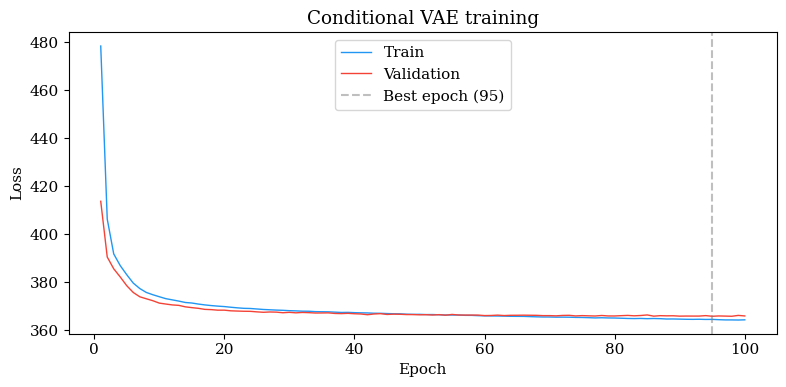

Saved to ../figures/cvae_training.png


In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

epochs = range(1, len(train_losses) + 1)
ax.plot(epochs, train_losses, color='#2196F3', linewidth=1, label='Train')
ax.plot(epochs, val_losses, color='#F44336', linewidth=1, label='Validation')
ax.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.5,
           label=f'Best epoch ({best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Conditional VAE training')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES / 'cvae_training.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "cvae_training.png"}')

## 6. Save checkpoint and load best model

In [7]:
model.load_state_dict(best_state)

torch.save({
    'model_state_dict': best_state,
    'config': {
        'input_dim': 2000, 'latent_dim': 32,
        'hidden_dims': [1024, 512, 128],
        'likelihood': 'nb', 'dropout': 0.1,
        'use_layer_norm': True,
        'n_clusters': n_clusters,
    },
    'val_loss': best_val_loss,
}, OUTPUTS / 'p6' / 'cvae_best_model.pt')
print(f'Checkpoint saved to {OUTPUTS / "p6" / "cvae_best_model.pt"}')

Checkpoint saved to ../outputs/p6/cvae_best_model.pt


## 7. Compute Fisher on forget and retain subsets

In [8]:
forget_ds = ConditionalAnnDataDataset(adata, forget_idx, n_clusters)
retain_ds = ConditionalAnnDataDataset(adata, retain_idx, n_clusters)
forget_loader = DataLoader(forget_ds, batch_size=128, shuffle=False)
retain_loader = DataLoader(retain_ds, batch_size=256, shuffle=False)

print('Computing forget-set Fisher...')
fisher_forget, n_f = compute_conditional_vae_fisher(model, forget_loader, device)
print(f'  {n_f} samples')

print('Computing retain-set Fisher...')
fisher_retain, n_r = compute_conditional_vae_fisher(model, retain_loader, device)
print(f'  {n_r} samples')

Computing forget-set Fisher...
  30 samples
Computing retain-set Fisher...
  28094 samples


## 8. Per-layer analysis

In [9]:
print(f'{"Layer":50s} {"Params":>10s} {"Cosine":>8s} {"EffRank(F)":>12s} {"EffRank(R)":>12s} {"Category"}')
print('-' * 110)

layer_data = []
categories = {}

for name in fisher_forget:
    ff = fisher_forget[name].flatten()
    fr = fisher_retain[name].flatten()
    n = len(ff)
    if n < 10:
        continue
    cos = cosine_sim(ff, fr)
    er_f = effective_rank(ff)
    er_r = effective_rank(fr)
    cat = vae_layer_category(name)
    layer_data.append({
        'name': name, 'n_params': n, 'cosine': cos,
        'eff_rank_f': er_f, 'eff_rank_r': er_r, 'category': cat
    })
    if cat not in categories:
        categories[cat] = {'f': [], 'r': []}
    categories[cat]['f'].append(ff)
    categories[cat]['r'].append(fr)
    print(f'{name:50s} {n:10,d} {cos:8.4f} {er_f:12.0f} {er_r:12.0f} {cat}')

Layer                                                  Params   Cosine   EffRank(F)   EffRank(R) Category
--------------------------------------------------------------------------------------------------------------
encoder.network.0.weight                            2,048,000   0.2829        32081       185401 Encoder
encoder.network.0.bias                                  1,024   0.3442          124          556 Encoder
encoder.network.1.weight                                1,024   0.1417          120           52 Encoder
encoder.network.1.bias                                  1,024   0.3530          151          711 Encoder
encoder.network.4.weight                              524,288   0.2079        30735       210734 Encoder
encoder.network.4.bias                                    512   0.4205          130          390 Encoder
encoder.network.5.weight                                  512   0.6595           60          329 Encoder
encoder.network.5.bias                          

## 9. fc_mean weight decomposition

The conditional VAE's `fc_mean` weight has shape `[2000, 1024 + n_clusters]`.
The first 1024 columns correspond to shared hidden features (same as standard VAE).
The last `n_clusters` columns correspond to cluster-specific routing weights.
Examine Fisher overlap separately for these two blocks.

In [10]:
# Find the fc_mean weight
fc_mean_key = None
for name in fisher_forget:
    if 'fc_mean' in name and 'weight' in name:
        fc_mean_key = name
        break
print(f'fc_mean key: {fc_mean_key}')
print(f'Shape: {fisher_forget[fc_mean_key].shape}')

ff_fc = fisher_forget[fc_mean_key]  # [2000, 1024+14]
fr_fc = fisher_retain[fc_mean_key]

last_hidden = ff_fc.shape[1] - n_clusters
print(f'Shared cols: 0:{last_hidden}, Cluster cols: {last_hidden}:{ff_fc.shape[1]}')

# Shared portion (first 1024 cols)
ff_shared = ff_fc[:, :last_hidden].flatten()
fr_shared = fr_fc[:, :last_hidden].flatten()
cos_shared = cosine_sim(ff_shared, fr_shared)

# Cluster-specific portion (last n_clusters cols)
ff_cluster = ff_fc[:, last_hidden:].flatten()
fr_cluster = fr_fc[:, last_hidden:].flatten()
cos_cluster = cosine_sim(ff_cluster, fr_cluster)

# Full fc_mean
cos_full = cosine_sim(ff_fc.flatten(), fr_fc.flatten())

print(f'\nfc_mean Fisher overlap decomposition:')
print(f'  Full fc_mean:        cosine = {cos_full:.4f}  ({ff_fc.numel():,} params)')
print(f'  Shared cols (h):     cosine = {cos_shared:.4f}  ({ff_shared.numel():,} params)')
print(f'  Cluster cols (c):    cosine = {cos_cluster:.4f}  ({ff_cluster.numel():,} params)')

fc_mean key: decoder.fc_mean.0.weight
Shape: torch.Size([2000, 1038])
Shared cols: 0:1024, Cluster cols: 1024:1038

fc_mean Fisher overlap decomposition:
  Full fc_mean:        cosine = 0.0327  (2,076,000 params)
  Shared cols (h):     cosine = 0.2217  (2,048,000 params)
  Cluster cols (c):    cosine = 0.0000  (28,000 params)


## 10. Global and per-category metrics

In [11]:
# Global metrics
ff_global = torch.cat([f.flatten() for f in fisher_forget.values()])
fr_global = torch.cat([f.flatten() for f in fisher_retain.values()])
global_cos = cosine_sim(ff_global, fr_global)
log_corr = torch.corrcoef(
    torch.stack([ff_global.log(), fr_global.log()])
)[0, 1].item()
n_total = len(ff_global)
top1 = top_k_overlap(ff_global, fr_global, int(0.01 * n_total))
top10 = top_k_overlap(ff_global, fr_global, int(0.1 * n_total))

print(f'Global cosine similarity: {global_cos:.4f}')
print(f'Log-Fisher correlation:   {log_corr:.4f}')
print(f'Top-1% overlap:           {top1:.4f}')
print(f'Top-10% overlap:          {top10:.4f}')
print(f'Total params:             {n_total:,}')
print()

# Per-category metrics
cat_results = {}
for cat in ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']:
    if cat in categories:
        ff_c = torch.cat(categories[cat]['f'])
        fr_c = torch.cat(categories[cat]['r'])
        cat_results[cat] = {
            'cosine': cosine_sim(ff_c, fr_c),
            'n_params': len(ff_c),
            'eff_rank_ratio_forget': effective_rank(ff_c) / len(ff_c),
            'eff_rank_ratio_retain': effective_rank(fr_c) / len(fr_c),
        }
        print(f'{cat:20s}  cosine={cat_results[cat]["cosine"]:.4f}  params={len(ff_c):,}')

Global cosine similarity: 0.4322
Log-Fisher correlation:   0.6911
Top-1% overlap:           0.2403
Top-10% overlap:          0.5160
Total params:             7,377,984

Encoder               cosine=0.4329  params=2,642,816
Bottleneck            cosine=0.5081  params=8,256
Decoder hidden        cosine=0.3462  params=598,912
Decoder output        cosine=0.2459  params=4,128,000


## 11. Comparison with standard VAE baseline

In [12]:
# Load NB26 canonical results
with open(OUTPUTS / 'p6' / 'fisher_overlap_results.json') as f:
    baseline = json.load(f)

print(f'{"Metric":25s} {"Standard VAE":>14s} {"Conditional VAE":>16s} {"Diff":>10s}')
print('=' * 70)
b_cos = baseline['vae']['global_cosine']
print(f'{"Global cosine":25s} {b_cos:14.4f} {global_cos:16.4f} {global_cos - b_cos:+10.4f}')
b_log = baseline['vae']['log_fisher_correlation']
print(f'{"Log-Fisher corr":25s} {b_log:14.4f} {log_corr:16.4f} {log_corr - b_log:+10.4f}')
print()

# Per-category comparison
print(f'{"Category":20s} {"Standard":>10s} {"Conditional":>12s} {"Diff":>10s}')
print('-' * 55)
for cat in ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']:
    b_val = baseline['vae']['per_category'][cat]['cosine']
    c_val = cat_results.get(cat, {}).get('cosine', float('nan'))
    print(f'{cat:20s} {b_val:10.4f} {c_val:12.4f} {c_val - b_val:+10.4f}')

# fc_mean decomposition comparison
b_fc_mean = baseline['vae']['per_category']['Decoder output']['cosine']
print(f'\nfc_mean shared cols:   {cos_shared:.4f} (vs standard decoder output: {b_fc_mean:.4f})')
print(f'fc_mean cluster cols:  {cos_cluster:.4f}')
clf_cos = baseline['classifier']['global_cosine']
print(f'Linear classifier:     {clf_cos:.4f}')

Metric                      Standard VAE  Conditional VAE       Diff
Global cosine                     0.3058           0.4322    +0.1265
Log-Fisher corr                   0.7274           0.6911    -0.0363

Category               Standard  Conditional       Diff
-------------------------------------------------------
Encoder                  0.2733       0.4329    +0.1596
Bottleneck               0.2912       0.5081    +0.2169
Decoder hidden           0.2317       0.3462    +0.1145
Decoder output           0.3618       0.2459    -0.1159

fc_mean shared cols:   0.2217 (vs standard decoder output: 0.3618)
fc_mean cluster cols:  0.0000
Linear classifier:     0.0181


## 12. Comparison figure

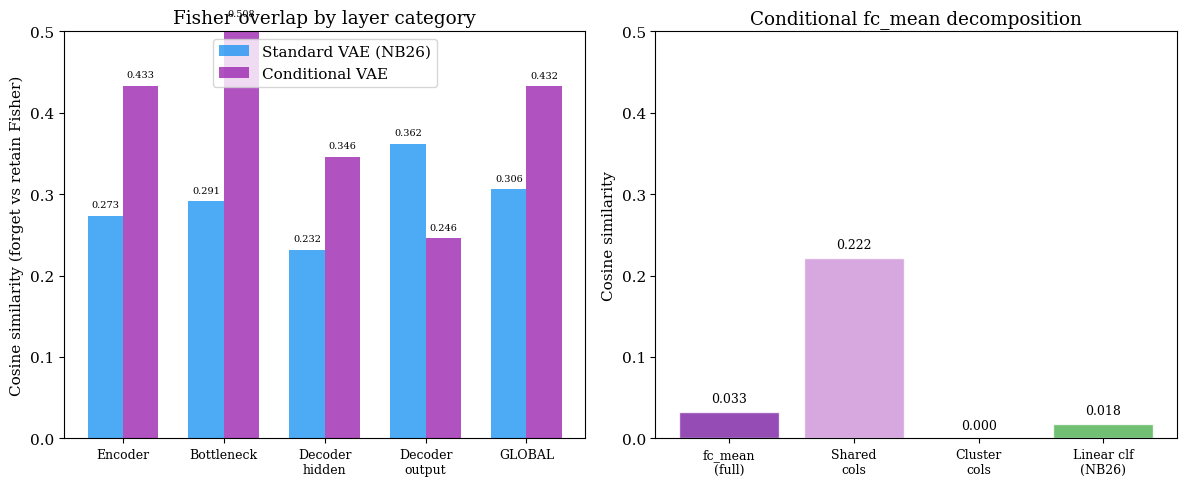

Saved to ../figures/fisher_conditional_comparison.png


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: category-level comparison (standard vs conditional vs classifier)
cat_names = ['Encoder', 'Bottleneck', 'Decoder\nhidden', 'Decoder\noutput', 'GLOBAL']

std_vals = [
    baseline['vae']['per_category']['Encoder']['cosine'],
    baseline['vae']['per_category']['Bottleneck']['cosine'],
    baseline['vae']['per_category']['Decoder hidden']['cosine'],
    baseline['vae']['per_category']['Decoder output']['cosine'],
    baseline['vae']['global_cosine'],
]
cond_vals = [
    cat_results.get('Encoder', {}).get('cosine', 0),
    cat_results.get('Bottleneck', {}).get('cosine', 0),
    cat_results.get('Decoder hidden', {}).get('cosine', 0),
    cat_results.get('Decoder output', {}).get('cosine', 0),
    global_cos,
]

x = np.arange(len(cat_names))
w = 0.35

bars1 = ax1.bar(x - w/2, std_vals, w, label='Standard VAE (NB26)', color='#2196F3', alpha=0.8)
bars2 = ax1.bar(x + w/2, cond_vals, w, label='Conditional VAE', color='#9C27B0', alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(cat_names, fontsize=9)
ax1.set_ylabel('Cosine similarity (forget vs retain Fisher)')
ax1.set_title('Fisher overlap by layer category')
ax1.legend()
ax1.set_ylim(0, 0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax1.text(bar.get_x() + bar.get_width() / 2, h + 0.008,
                     f'{h:.3f}', ha='center', va='bottom', fontsize=7)

# Right: fc_mean decomposition
decomp_labels = ['fc_mean\n(full)', 'Shared\ncols', 'Cluster\ncols', 'Linear clf\n(NB26)']
decomp_vals = [cos_full, cos_shared, cos_cluster, clf_cos]
colors = ['#7B1FA2', '#CE93D8', '#FF9800', '#4CAF50']

bars3 = ax2.bar(range(len(decomp_labels)), decomp_vals, color=colors, alpha=0.8,
                edgecolor='white')
ax2.set_xticks(range(len(decomp_labels)))
ax2.set_xticklabels(decomp_labels, fontsize=9)
ax2.set_ylabel('Cosine similarity')
ax2.set_title('Conditional fc_mean decomposition')
ax2.set_ylim(0, 0.5)

for bar in bars3:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, h + 0.008,
             f'{h:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_conditional_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "fisher_conditional_comparison.png"}')

## 13. Save results

In [15]:
results = {
    'model': 'conditional_vae',
    'global_cosine': global_cos,
    'log_fisher_correlation': log_corr,
    'top_1pct_overlap': top1,
    'top_10pct_overlap': top10,
    'total_params': n_total,
    'global_eff_rank_forget': effective_rank(ff_global),
    'global_eff_rank_retain': effective_rank(fr_global),
    'per_category': cat_results,
    'per_layer': layer_data,
    'fc_mean_decomposition': {
        'full_cosine': cos_full,
        'shared_cols_cosine': cos_shared,
        'cluster_cols_cosine': cos_cluster,
        'n_shared_cols': last_hidden,
        'n_cluster_cols': n_clusters,
    },
    'val_loss': best_val_loss,
    'metadata': {
        'n_clusters': n_clusters,
        'latent_dim': 32,
        'hidden_dims': [1024, 512, 128],
        'n_forget': len(forget_idx),
        'n_retain': len(retain_idx),
        'damping': 1e-8,
        'epochs': 100,
        'best_epoch': best_epoch,
        'lr': 1e-3,
        'seed': 42,
        'elapsed_seconds': elapsed,
    }
}

out_path = OUTPUTS / 'p6' / 'fisher_overlap_conditional.json'
with open(out_path, 'w') as f:
    json.dump(results, f, indent=2, default=float)
print(f'Results saved to {out_path}')
print()
print('=== Summary ===')
print(f'Conditional VAE global cosine:  {global_cos:.4f}')
print(f'Standard VAE global cosine:     {b_cos:.4f}')
print(f'fc_mean shared cols cosine:     {cos_shared:.4f}')
print(f'fc_mean cluster cols cosine:    {cos_cluster:.4f}')
print(f'Linear classifier cosine:       {clf_cos:.4f}')

Results saved to ../outputs/p6/fisher_overlap_conditional.json

=== Summary ===
Conditional VAE global cosine:  0.4322
Standard VAE global cosine:     0.3058
fc_mean shared cols cosine:     0.2217
fc_mean cluster cols cosine:    0.0000
Linear classifier cosine:       0.0181
